<a href="https://colab.research.google.com/github/connor-verheyen/DataDrivenGranularHydrogels/blob/main/analysis/Model_Predicting_Extrusion_FinalModel_BinaryStability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import basic libraries 
import os 
import pandas as pd 
import numpy as np 
import scipy as sp 
import math
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
# Read the excel sheet into a dataframe 
test = pd.read_excel('https://github.com/connor-verheyen/DataDrivenGranularHydrogels/blob/main/data/Dataset_FollowUp_QuantitativeExtrusion_Compiled_ExtractedValues.xlsx?raw=true',sheet_name='Sheet1',header=0).rename(columns={'Unnamed: 0': 'Trial ID'})

# Generate a concatenated string identifier composed of the unique trial identifier (first portion of string) and the unique sample identifier (second portion of string)
test['String ID'] = [str(trial_id) + '_' + str(sample_id) for trial_id, sample_id in zip(test['Trial ID'],test['Unique ID'])]; #test['Numerical ID'] = pd.factorize(test['String ID'])[0]

In [ ]:
# Read the fitted rheo params into a dataframe 
params = pd.read_excel('https://github.com/connor-verheyen/DataDrivenGranularHydrogels/blob/main/data/Dataset_FollowUpRheologicalStudy_FittedParamsForExtrusionModeling.xlsx?raw=true',sheet_name='Sheet1',header=0,index_col=0)

# Categorical map to ensure that the trial names match between datasheets 
trial_name_map = {'Prelim_DiffConc_DiffSpeed': 'Diff_conc', 
                  'Prelim_DiffConc_20cmCath': 'Diff_conc',
                  'DiffConc_DiffCaths': 'Diff_conc', 
                  'DiffConc_DiffNeedleDiameters': 'Diff_conc',
                  'DiffConc_DiffExtrusionSpeeds': 'Diff_conc', 
                  'Unswelled_DiffNeedleDiams': 'No_reswelling',
                  'DiffVolFracs_DiffCathLengths': 'Diff_volfrac', 
                  'DiffVolFracs_DiffNeedleDiams': 'Diff_volfrac'}

# Map the correct labels to a new column 
test['TrialName_forMatch'] = test['TrialName'].map(trial_name_map)

# Duplicate the column in the other sheet and change the column name so it matches 
params['TrialName_forMatch'] = params['TrialName']

In [ ]:
# Assign the categorical resuspension details and map them to an ordinal categorical variable
resuspension_details_map = {'Diff_conc':'Single Wash',
                            'No_reswelling':'Single Wash',
                            'Diff_volfrac':'Multi Wash'}

test['Resuspension Details'] = test['TrialName_forMatch'].map(resuspension_details_map)

resuspension = {'Single Wash': 1,
                 'Multi Wash': 2,}
test['Resuspension_encoded'] = test['Resuspension Details'].map(resuspension) # Ordinal categorical 

In [ ]:
# Go through each of the unique samples in the extrusion dataset and pair them with their corresponding rheological measurements
level_0 = []
for string_id in test['String ID'].unique():

  ext_data = test[test['String ID'] == string_id].copy()

  if np.isnan(ext_data['Microgel Conc. (%)'].iloc[0]) == True: # Skip over the control trials (where either air, water, or corn syrup was used in place of microgels)
    continue  
  
  if ext_data['Ext. Length (cm)'].iloc[0]>3: # Skip over the trials with longer extrusion lengths (those use catheters rather than standard printing nozzles/injection needles)
    continue 

  rheo_data = params[(params['TrialName_forMatch']==ext_data['TrialName_forMatch'].iloc[0]) &     # Match the trial name from the rheology data to the trial name from the extrusion data
                     (params['Microgel Conc. (%)']==ext_data['Microgel Conc. (%)'].iloc[0]) &     # Match the microgel conc from the rheology data to the microgel conc from the extrusion data
                     (params['Est. Vol. Fraction']==ext_data['Est. Vol. Fraction'].iloc[0]) &     # Match the vol frac from the rheology data to the vol frac from the extrusion data
                     ((params['TestName']=='OscStress') | (params['TestName']=='OscStrain'))      # Get the osc stress and osc strain values and average them 
                     ]
  
  vals_to_transfer = ['Storage_0','Loss_0','Complex_0','Tand_0','YS_breakdown_33','YStrain_breakdown_33']
  for val in vals_to_transfer:
    ext_data[val] = rheo_data[val].mean()
    
  rheo_data2 =params[(params['TrialName_forMatch']==ext_data['TrialName_forMatch'].iloc[0]) &     # Match the trial name from the rheology data to the trial name from the extrusion data
                     (params['Microgel Conc. (%)']==ext_data['Microgel Conc. (%)'].iloc[0]) &     # Match the microgel conc from the rheology data to the microgel conc from the extrusion data
                     (params['Est. Vol. Fraction']==ext_data['Est. Vol. Fraction'].iloc[0]) &     # Match the vol frac from the rheology data to the vol frac from the extrusion data
                     ((params['TestName']=='FlowCurve') | (params['TestName']=='RevFlowCurve'))   # Get the flow curve and rev flow curve values and average them
                     ]
  
  vals_to_transfer = ['Viscosity_0.1/s']
  for val in vals_to_transfer:
    ext_data[val] = rheo_data2[val].mean()

  level_0.append(ext_data)

# Concatenate the results and get a unique ID for each of the trials in the dataset 
concat = pd.concat(level_0).reset_index().rename(columns={'Unique ID': 'Trial ID','index':'Unique ID'})

In [ ]:
# Define dictionaries for ordinal categorical data label encoding 

stability_map = {'Stable': 1, 
                   'Unstable': 0}

concat['StabilityLabel'] = concat['Ext. Stability'].map(stability_map) # Ordinal categorical                    

In [ ]:
# Imports for stratified k-fold cross-validation and grid-search cross-validation 
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, GroupKFold, GroupShuffleSplit

# Import for constructing a ML pipeline 
from sklearn.pipeline import Pipeline

# Imports for evaluating the predictive power of the trained models 
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Imports for different classifier algorithms 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Function to perform manual nested cross validation
# Allows you to store all inner cross-validation results, all model params, all outer testing and prediction results, and best models and their unbiased accuracy scores 

def manual_nested_cross_validation_binary_class(model, grid, cv_inner, cv_outer, algo_name, X, y, scoring, refit, groups): # Note, model can also be a sklean pipeline 
  
  outer_results = [] # hold all of the results from the outer cross-validation (Xtest,ytest,yhat) -> outer loop = unbiased evaluation of model accuracy/usefulness of the best models selected during the inner loop 
  
  inner_results = [] # hold all of the results from the inner cross-validation (inner training accuracy (mean,std), inner test accuracy (mean,std), all model parameters) -> inner loop = hyperparameter tuning 
  
  best_models = [] # hold all of the best-performing models from the inner cross-validation (stores the model objects, can be used to fit and predict if given other data)
  
  outer_Accuracy = []; outer_Precision = []; outer_Recall = []; outer_ROC_AUC = []; outer_f1 = [] # hold all of the scores after training the best inner model and testing on the outer test set (compare yhat from best inner model to outer ytest)
  
  # Go through each of the outer train/test sets -> note, this works when using StratifiedKFold, not sure if it works with all sklearn cross-validation functions... 
  for train_ix, test_ix in cv_outer.split(X,y,groups=groups): # split generates an ndarray of values corresponding to the indices of the train and test data for each fold  

    # Split the data according to membership in the train or test set -> turn the ndarray (from split) into a list and then use iloc to index the dataset at the correct locations 
    X_train, X_test = X.iloc[train_ix.tolist(),:].reset_index(drop=True), X.iloc[test_ix.tolist(), :].reset_index(drop=True) # inputs 
    
    y_train, y_test = y.iloc[train_ix.tolist()].reset_index(drop=True), y.iloc[test_ix.tolist()].reset_index(drop=True) # outputs 

    # Define the inner grid search 
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, return_train_score =True, cv=cv_inner, scoring=scoring, error_score=0, refit=refit)

	  # Execute the inner grid search -> outer training and test sets will be further broken into inner training and inner validation sets by GridSearch
    grid_result = grid_search.fit(X_train, y_train, groups=groups[train_ix])

    # Go through each of the scoring metrics you defined and get the mean test scores, std test scores, mean train scores, and std train scores for each of the models 
    values_to_store = ['mean_test_','std_test_','mean_train_','std_train_']; inner_scores = {}
    for scorer in scoring.keys():
    
      for values in values_to_store: 
    
        inner_scores[values+scorer] = grid_result.cv_results_[values+scorer] # store all of the results in a dict (mean and std computed based on each of the unique folds of the inner loop ) 
    
    scores = pd.DataFrame(inner_scores)

    # Get the parameters for each of the models 
    parameters = pd.DataFrame(grid_result.cv_results_['params'])

    # Concatenate the inner scores and parameters, rank by test score, drop the scores of 0 (parameter combinations that don't work), and reset index 
    results_df = pd.concat([scores,parameters],axis=1).sort_values(by=('mean_test_'+refit),ascending=False)
    
    results_df = results_df[results_df['mean_test_'+refit] != 0].reset_index(drop=True)
    
    inner_results.append(results_df)

	  # Get the best performing model selected by GridSearch (model was re-fit on the entire outer training set (=inner train + inner validation), accomplished by setting "refit" = True)
    best_model = grid_result.best_estimator_; best_models.append(best_model) # Add the best model to the list 

	  # Make predictions using the best performing model (trained on entire outer training set) on the hold out dataset (outer test set)
    yhat = best_model.predict(X_test) # Predicted class labels for samples in X_test 
    
    yprob = best_model.predict_proba(X_test) # Predicted probability estimates for a given class for samples in X_test (For a multi_class problem, if multi_class is set to be “multinomial” the softmax function is used to find the predicted probability of each class. )

	  # Evaluate the model accuracy by comparing model predictions to the hold out dataset (outer test set) -> Comment out the ones you don't want to use 
    accuracy = accuracy_score(y_test, yhat); outer_Accuracy.append(accuracy) # Add the outer test accuracy to the list 

    precision = precision_score(y_test, yhat, average='weighted',zero_division=0); outer_Precision.append(precision) # Add the outer test precision to the list 

    recall = recall_score(y_test, yhat, average='weighted', ); outer_Recall.append(recall) # Add the outer test recall to the list 

    try: 
      roc_auc = roc_auc_score(y_test, yprob[:, 1], average='weighted',); outer_ROC_AUC.append(roc_auc) # Add the outer test roc auc to the list 
    except: 
      pass #print('Could not compute ROC AUC')

    f1 = f1_score(y_test, yhat, average='weighted',); outer_f1.append(f1) # Add the outer f1 to the list 

    # Create a dataframe with outer X_test, outer ytest, outer yhat, and outer yprob 
    y_test_df = pd.DataFrame({'y_test': y_test}); yhat_df = pd.DataFrame({'yhat': yhat}); yprob_df = pd.DataFrame(data=yprob) # Turn the ytest, yhat, and yprob values into dataframes
    
    outer = pd.concat([X_test.reset_index(drop=True), y_test_df.reset_index(drop=True), yhat_df.reset_index(drop=True), yprob_df.reset_index(drop=True)],axis=1)
    
    outer_results.append(outer) # Add the outer results to the list 

  # Concatenate the dataframes produced in the loops -> keys correspond to the specific fold within the k-fold cross-validation 
  inner_results_df = pd.concat(inner_results,keys=np.arange(0,len(inner_results)))

  outer_results_df = pd.concat(outer_results,keys=np.arange(0,len(outer_results)))
  
  best_models_df = pd.concat([pd.DataFrame({'best_model': best_models}), 
                              pd.DataFrame({'outer_Accuracy': outer_Accuracy}),  # Comment out the ones you don't want to add to the dataframe
                              pd.DataFrame({'outer_Precision': outer_Precision}), 
                              pd.DataFrame({'outer_Recall': outer_Recall}), 
                              pd.DataFrame({'outer_ROC_AUC': outer_ROC_AUC}), 
                              pd.DataFrame({'outer_F1': outer_f1})
                              ], axis=1)

  # Print the classification accuracy 
  print(f'Best-performing {algo_name} model inner {refit} was {round(inner_results_df.xs(key=0,level=1)["mean_test_"+refit].mean(),3)} +/- {round(inner_results_df.xs(key=0,level=1)["std_test_"+refit].mean(),3)}')
  print(f'Best-performing {algo_name} model outer {refit} was {round(np.mean(best_models_df["outer_"+refit]),3)} +/- {round(np.std(best_models_df["outer_"+refit]),3)}')

  return inner_results_df, outer_results_df, best_models_df

In [ ]:
# Features 
X = concat[['Ext. Diam. (mm)', # Ext. Param
            'Ext. Length (cm)', # Ext. Param
            'Est. Vol. Fraction', # Mat. Param
            'Fluid Ca2+ (mM)', # Mat. Param
            'Resuspension_encoded', # Mat. Param
            'Syringe Diam. (mm)', # Ext. Param
            'Microgel Conc. (%)', # Mat. Param
            'Microgel Size (mm)', # Mat. Param
            'Speed (mm/sec)', # Ext. Param
            'Complex_0', # Mat. Behav
            'YS_breakdown_33', # Mat. Behav
            'YStrain_breakdown_33', # Mat. Behav
            ]].copy()

# Labels
y = concat['StabilityLabel']

# Get the corresponding group labels so you can break up the trials accordingly 
groups = concat['Unique ID']

In [ ]:
# Build a dictionary to hold all models and sub-dictionaries of model hyperparameters -> accessible via "name" key 
algo_dict = {}

# Random Forest 
name = 'Random Forest'; model = RandomForestClassifier()

n_estimators = [10, 100, 1000]; max_features = ['sqrt', 'log2']; n_jobs=[-1]

grid = dict(n_estimators=n_estimators,max_features=max_features, n_jobs=n_jobs)

algo_dict[name] = {'model': model, 'grid': grid}

# Gradient Boosting
name = 'Gradient Boosting'; model = GradientBoostingClassifier()

#n_estimators = [10, 100, 1000]; learning_rate = [0.001, 0.01, 0.1]; subsample = [0.5, 0.7, 1.0]; max_depth = [3, 7, 9]
n_estimators = [10, 100]; learning_rate = [0.01, 0.1]; subsample = [0.5, 0.7]; max_depth = [3, 7] # Cut out the most expensive gradient boosting models to train and decrease the number of models that must be built

grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)

algo_dict[name] = {'model': model, 'grid': grid}

In [ ]:
# Configure the inner cross validation procedure -> used for hyperparameter tuning 
gkf_inner = GroupShuffleSplit(n_splits=3,random_state=0)

# Configure the outer cross validation procedure -> used for evaluating the accuracy & generalizability of the tuned model on unseen test data 
gkf_outer = GroupShuffleSplit(n_splits=5,random_state=0)

In [ ]:
# Build a dictionary to hold the scorer functions for evaluating the predictive power of the trained models 
scoring_dict = {'Accuracy': make_scorer(accuracy_score),
                'Precision': make_scorer(precision_score,average='weighted',zero_division=0), 
                'Recall': make_scorer(recall_score, average='weighted'), 
                }
refit = 'Accuracy'

In [ ]:
import time
start_time = time.time()

inner_results = []; outer_results = []; best_models = [] # lists to store all of the results so you can concatenate into multi-index df at the end
# Go through each algorithm and perform inner grid search and outer cross validation and store all results 
for key in algo_dict.keys():
  model = algo_dict[key]['model'] # get the model from the model dict 
  
  grid = algo_dict[key]['grid'] # get the grid search space from the grid dict 
  
  grid_for_pipe = {'model__'+key: grid[key] for key in grid.keys()} # go through existing grid and modify the names with "model__" format so they can be used with the pipeline object 

  # Build data pipeline that will A) fit/transform the train and transform the test and then B) apply the algorithm 
  pipe = Pipeline([
                   ('model', model) # model was defined by the model dict (accessed within the loop)
                   ])
  
  # Run the manual nested cross validation 
  inner, outer, best = manual_nested_cross_validation_binary_class(pipe, grid_for_pipe, gkf_inner, gkf_outer, key, X, y, scoring=scoring_dict, refit=refit, groups=groups)
  
  # Store the results of the inner CV model tuning, outer CV model testing, and information re: the best performing models from each loop 
  inner_results.append(inner); outer_results.append(outer); best_models.append(best) 

# Print out the amount of time it takes to complete nested cross-validation for the models 
print("--- %.3f minutes ---" % ((time.time() - start_time)/60))

Best-performing Random Forest model inner Accuracy was 0.933 +/- 0.025
Best-performing Random Forest model outer Accuracy was 0.909 +/- 0.086
Best-performing Gradient Boosting model inner Accuracy was 0.933 +/- 0.025
Best-performing Gradient Boosting model outer Accuracy was 0.936 +/- 0.062
--- 1.051 minutes ---


In [ ]:
# Compile the inner cross-validation results, the outer cross-validation results, and the best-performing models and their outer accuracy scores
compiled_inner_crossval = pd.concat(inner_results,keys=algo_dict.keys()); compiled_outer_crossval = pd.concat(outer_results,keys=algo_dict.keys()); compiled_best_models = pd.concat(best_models,keys=algo_dict.keys())

# Drop the columns you don't want to plot for the evaluation metrics 
evaluation = compiled_best_models.drop(columns={'best_model','outer_Precision','outer_Recall'})

# Check out the mean evaluation metrics for each configured algorithm  
compiled_best_models.reset_index().drop(columns={'level_1'}).groupby('level_0').mean()

# Check out the mean evaluation metrics for the averaged ensemble model 
compiled_best_models.mean().to_frame().T.rename(index={0:'Averaged Model'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


,outer_Accuracy,outer_Precision,outer_Recall,outer_ROC_AUC,outer_F1
Averaged Model,0.922727,0.931414,0.922727,0.975965,0.922131


In [ ]:
# Output the descriptive statistics for the averaged model evaluation metrics 
round(evaluation.reset_index().groupby('level_1').mean().describe().iloc[1:],3)

,outer_Accuracy,outer_ROC_AUC,outer_F1
mean,0.923,0.976,0.922
std,0.065,0.030,0.062
min,0.818,0.930,0.826
25%,0.932,0.965,0.926
50%,0.932,0.985,0.929
75%,0.932,1.000,0.930
max,1.000,1.000,1.000


In [ ]:
# Print the mean+std and median for each averaged model metric (evaluated on unseen outer loop data)
for col in evaluation.columns: 
  avgd = round(evaluation.reset_index().groupby('level_1')[col].mean().describe().iloc[1:],3)
  print(col.lstrip('outer_'))
  print(' Mean +/- SD = ',avgd['mean'],'+/-',avgd['std'])
  print(' Median = ',avgd['50%'],'\n')

Accuracy
 Mean +/- SD =  0.923 +/- 0.065
 Median =  0.932 

ROC_AUC
 Mean +/- SD =  0.976 +/- 0.03
 Median =  0.985 

F1
 Mean +/- SD =  0.922 +/- 0.062
 Median =  0.929 



In [ ]:
# Now set up another CV and execute the final grid search optimization

# Build a dictionary to hold the scorer functions for evaluating the predictive power of the trained models 
scoring_dict = {'Accuracy': make_scorer(accuracy_score),
                'Precision': make_scorer(precision_score,), 
                'Recall': make_scorer(recall_score,), 
                }
refit = 'Accuracy'

# Configure the final cross validation procedure -> used for tuning the final model 
cv_final = GroupShuffleSplit(n_splits=5,random_state=1)

# Save the best models from the grid search and use them to fit the entire dataset 

search_results=[]; best_models=[]
# Go through each algorithm and perform inner grid search and outer cross validation and store all results 
for key in algo_dict.keys():
  model = algo_dict[key]['model'] # get the model from the model dict 
  
  grid = algo_dict[key]['grid'] # get the grid search space from the grid dict 
  
  grid_for_pipe = {'model__'+key: grid[key] for key in grid.keys()} # go through existing grid and modify the names with "model__" format so they can be used with the pipeline object 

  # Build data pipeline that will A) fit/transform the train and transform the test and then B) apply the algorithm 
  pipe = Pipeline([
                   ('model', model) # model was defined by the model dict (accessed within the loop)
                   ])
  
  # Define the final grid search 
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, return_train_score =True, cv=cv_final, scoring=scoring_dict, error_score=0, refit=refit)

	# Execute the final grid search -> outer training and test sets will be further broken into inner training and inner validation sets by GridSearch
  grid_result = grid_search.fit(X, y, groups=groups)

  # Go through each of the scoring metrics you defined and get the mean test scores, std test scores, mean train scores, and std train scores for each of the models 
  values_to_store = ['mean_test_','std_test_','mean_train_','std_train_']; inner_scores = {}
  for scorer in scoring_dict.keys():
    
    for values in values_to_store: 
    
      inner_scores[values+scorer] = grid_result.cv_results_[values+scorer] # store all of the results in a dict (mean and std computed based on each of the unique folds of the inner loop ) 
    
  scores = pd.DataFrame(inner_scores)

  # Get the parameters for each of the models 
  parameters = pd.DataFrame(grid_result.cv_results_['params'])

  # Concatenate the inner scores and parameters, rank by test score, drop the scores of 0 (parameter combinations that don't work), and reset index 
  results_df = pd.concat([scores,parameters],axis=1).sort_values(by=('mean_test_'+refit),ascending=False)
    
  results_df = results_df[results_df['mean_test_'+refit] != 0].reset_index(drop=True)
    
  search_results.append(results_df)

	# Get the best performing model selected by GridSearch (model was re-fit on the entire outer training set (=inner train + inner validation), accomplished by setting "refit" = True)
  best_model = grid_result.best_estimator_; best_models.append(best_model) # Add the best model to the list 

In [ ]:
# Compile the cross-validated grid search results 
final_search_results = pd.concat(search_results,keys=algo_dict.keys()); 

# Get the highest-scoring model from the list of best models for each algorithm (allows you to select for the algorithm with optimal hyperparameters)
rf = best_models[0] 

gbm = best_models[1] 

# Store the selected models in a new dict
selected = {'RF': rf, 'GBM': gbm}

In [ ]:
# Fit the final selected models to the ENTIRE available dataset 
rf.fit(X,y); gbm.fit(X,y);

In [ ]:
# Create synthetic n-dimensional dataset (based on training data) and then visualize 2-dimensional slices / maps of the n-dimensional space 

# Generate possible combinations of features 

import itertools

unique_vals_manual = {}

unique_vals_manual['Ext. Diam. (mm)'] = np.array([0.84,1.54])
unique_vals_manual['Ext. Length (cm)'] = np.array([0,2.5])
unique_vals_manual['Est. Vol. Fraction'] = np.array([0.65,0.9])
unique_vals_manual['Fluid Ca2+ (mM)'] = np.array([0.9,3])
unique_vals_manual['Resuspension_encoded'] = np.array([1,2])
unique_vals_manual['Syringe Diam. (mm)'] = np.array([11.9,14.4])
unique_vals_manual['Microgel Conc. (%)'] = np.array([0.25,2])
unique_vals_manual['Microgel Size (mm)'] = np.array([0.250,0.689])
unique_vals_manual['Speed (mm/sec)'] = np.array([0.1,1])
unique_vals_manual['Complex_0'] = np.array([1250,2500]) 
unique_vals_manual['YS_breakdown_33'] = np.array([30,300]) 
unique_vals_manual['YStrain_breakdown_33'] = np.array([6,24])

other_vars_constant = pd.DataFrame(list(itertools.product(*unique_vals_manual.values())), columns=unique_vals_manual.keys()) # Use itertools to generate every possible feature combination. Combine all of the possible feature combinations into a single dataframe 

# Compute class predictions and probabilities (of each class) for each possible feature combination  
level_0 = []
for key in selected.keys(): 
  
  copy = other_vars_constant.copy() # Copy the dataframe where features are varied while others are held constant 
  
  copy['Pred_class'] = selected[key].predict(other_vars_constant[X.columns])

  copy['Pred_probability'] = selected[key].predict_proba(other_vars_constant[X.columns])[:,1]

  level_0.append(copy)

other_vars_constant = pd.concat(level_0,keys=selected.keys()).reset_index().drop(columns='level_1').rename(columns={'level_0':'Model'})

In [ ]:
# Set seaborn plotting styles 
sns.set(context='talk', font_scale=0.9, style='ticks',palette='Purples_d')

In [ ]:
# To export the processed input (X) and output data (y) as a combined dataframe 
pd.concat([X,y],axis=1).to_csv('Data_for_Model_Predicting_Extrusion_FinalModel_BinaryStability.csv')

# To export the matrix of data-driven predictions as a dataframe
other_vars_constant.to_csv('Predictions_for_Model_Predicting_Extrusion_FinalModel_BinaryStability.csv')

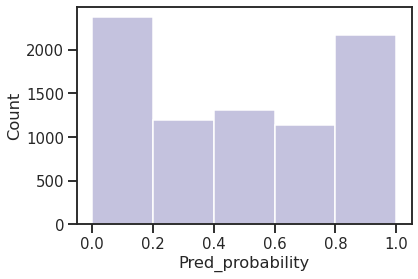

In [ ]:
# To visualize the distribution of data-driven predictions
sns.histplot(other_vars_constant['Pred_probability'],bins=5)

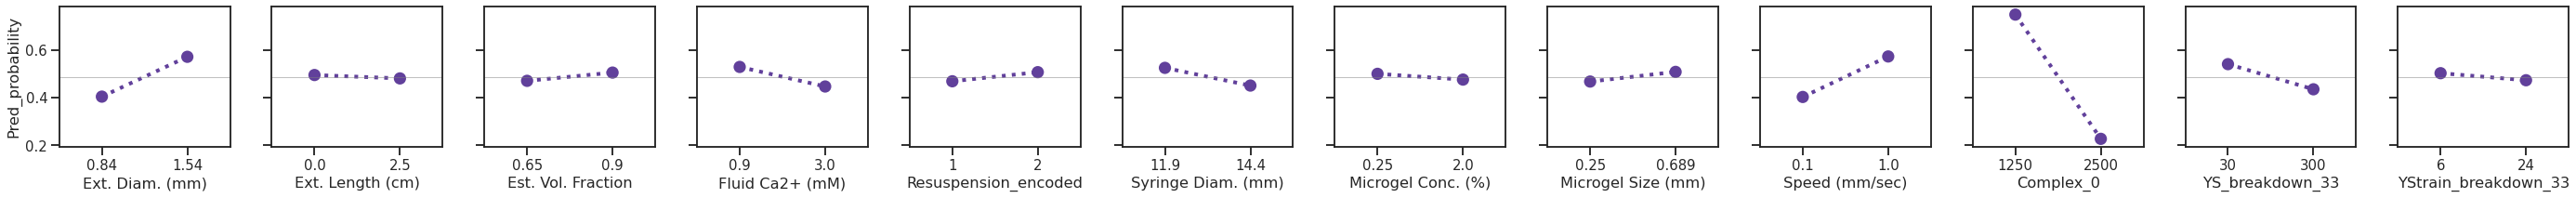

In [ ]:
# Define the columns you want to plot 
vars_to_iterate = X.columns

# Define the number of rows and columns 
rows=1;cols=len(vars_to_iterate)
fig,ax=plt.subplots(rows,cols,figsize=(cols*3.25,rows*3.25),sharey=True)

color = sns.color_palette(palette='Purples',n_colors=4)[3]

i=0
for variable in vars_to_iterate: 
  sns.pointplot(x=variable,y='Pred_probability',data=other_vars_constant,ax=ax[i],ci=95,linestyles=':',color=color); 
  ax[i].axhline(other_vars_constant['Pred_probability'].mean(),c='grey',alpha=0.5,linewidth=1); 
  i+=1
[ax[c].set_ylabel('') for c in range(1,cols)]
fig.tight_layout()

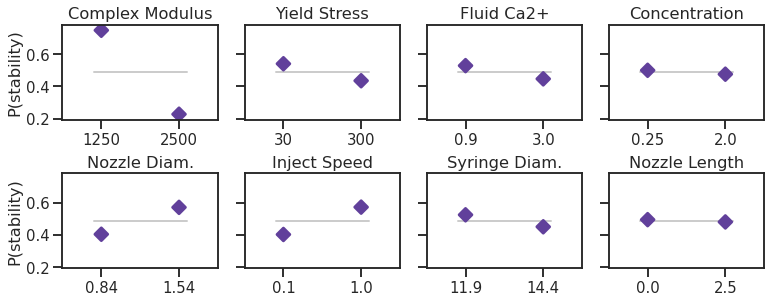

In [ ]:
rows=2;cols=4
fig,ax=plt.subplots(rows,cols,figsize=(cols*2.75,rows*2.25),sharey=True)

color = sns.color_palette(palette='Purples',n_colors=4)[3]; linestyles=':'; join=False; linewidth=2; markers='D'; scale=0.9; errwidth=None; capsize=0.2

sns.pointplot(x='Complex_0',y='Pred_probability',data=other_vars_constant,ax=ax[0,0],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth)
ax[0,0].set_title('Complex Modulus'); 

sns.pointplot(x='YS_breakdown_33',y='Pred_probability',data=other_vars_constant,ax=ax[0,1],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[0,1].set_title('Yield Stress'); 

sns.pointplot(x='Fluid Ca2+ (mM)',y='Pred_probability',data=other_vars_constant,ax=ax[0,2],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[0,2].set_title('Fluid Ca2+'); 

sns.pointplot(x='Microgel Conc. (%)',y='Pred_probability',data=other_vars_constant,ax=ax[0,3],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[0,3].set_title('Concentration'); 

sns.pointplot(x='Ext. Diam. (mm)',y='Pred_probability',data=other_vars_constant,ax=ax[1,0],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,0].set_title('Nozzle Diam.')

sns.pointplot(x='Speed (mm/sec)',y='Pred_probability',data=other_vars_constant,ax=ax[1,1],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,1].set_title('Inject Speed'); 

sns.pointplot(x='Syringe Diam. (mm)',y='Pred_probability',data=other_vars_constant,ax=ax[1,2],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,2].set_title('Syringe Diam.'); 

sns.pointplot(x='Ext. Length (cm)',y='Pred_probability',data=other_vars_constant,ax=ax[1,3],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,3].set_title('Nozzle Length'); 

#[sns.despine(ax=ax,top=True,right=True,left=True,trim=True) for ax in plt.gcf().axes] #[sns.despine(ax=ax,top=True,right=True,left=False,trim=False) for ax in plt.gcf().axes] #sns.despine(ax=ax[0,0],top=True,right=True,left=False); sns.despine(ax=ax[0,1],top=True,right=True,left=True); 
ax[0,0].set_ylabel('P(stability)'); ax[1,0].set_ylabel('P(stability)'); [ax[r,c].set_ylabel('') for c in range(1,4) for r in range(0,2)]
[ax.axhline(other_vars_constant['Pred_probability'].mean(),xmin=0.2,xmax=0.8,c='grey',alpha=0.4,linewidth=2,linestyle='-',zorder=-1) for ax in plt.gcf().axes] #[ax.axhline(other_vars_constant['Pred_probability'].mean(),xmin=0,xmax=1,c='grey',alpha=0.5,linewidth=1,linestyle='-',zorder=-1) for ax in plt.gcf().axes]; 
#[ax[r,0].set_yticks([0.3,0.5,0.7,]) for r in range(0,2)]#ax[0,0].set_yticklabels(['.4','.6','.8']); 
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout(h_pad=0.5, w_pad=0.75)

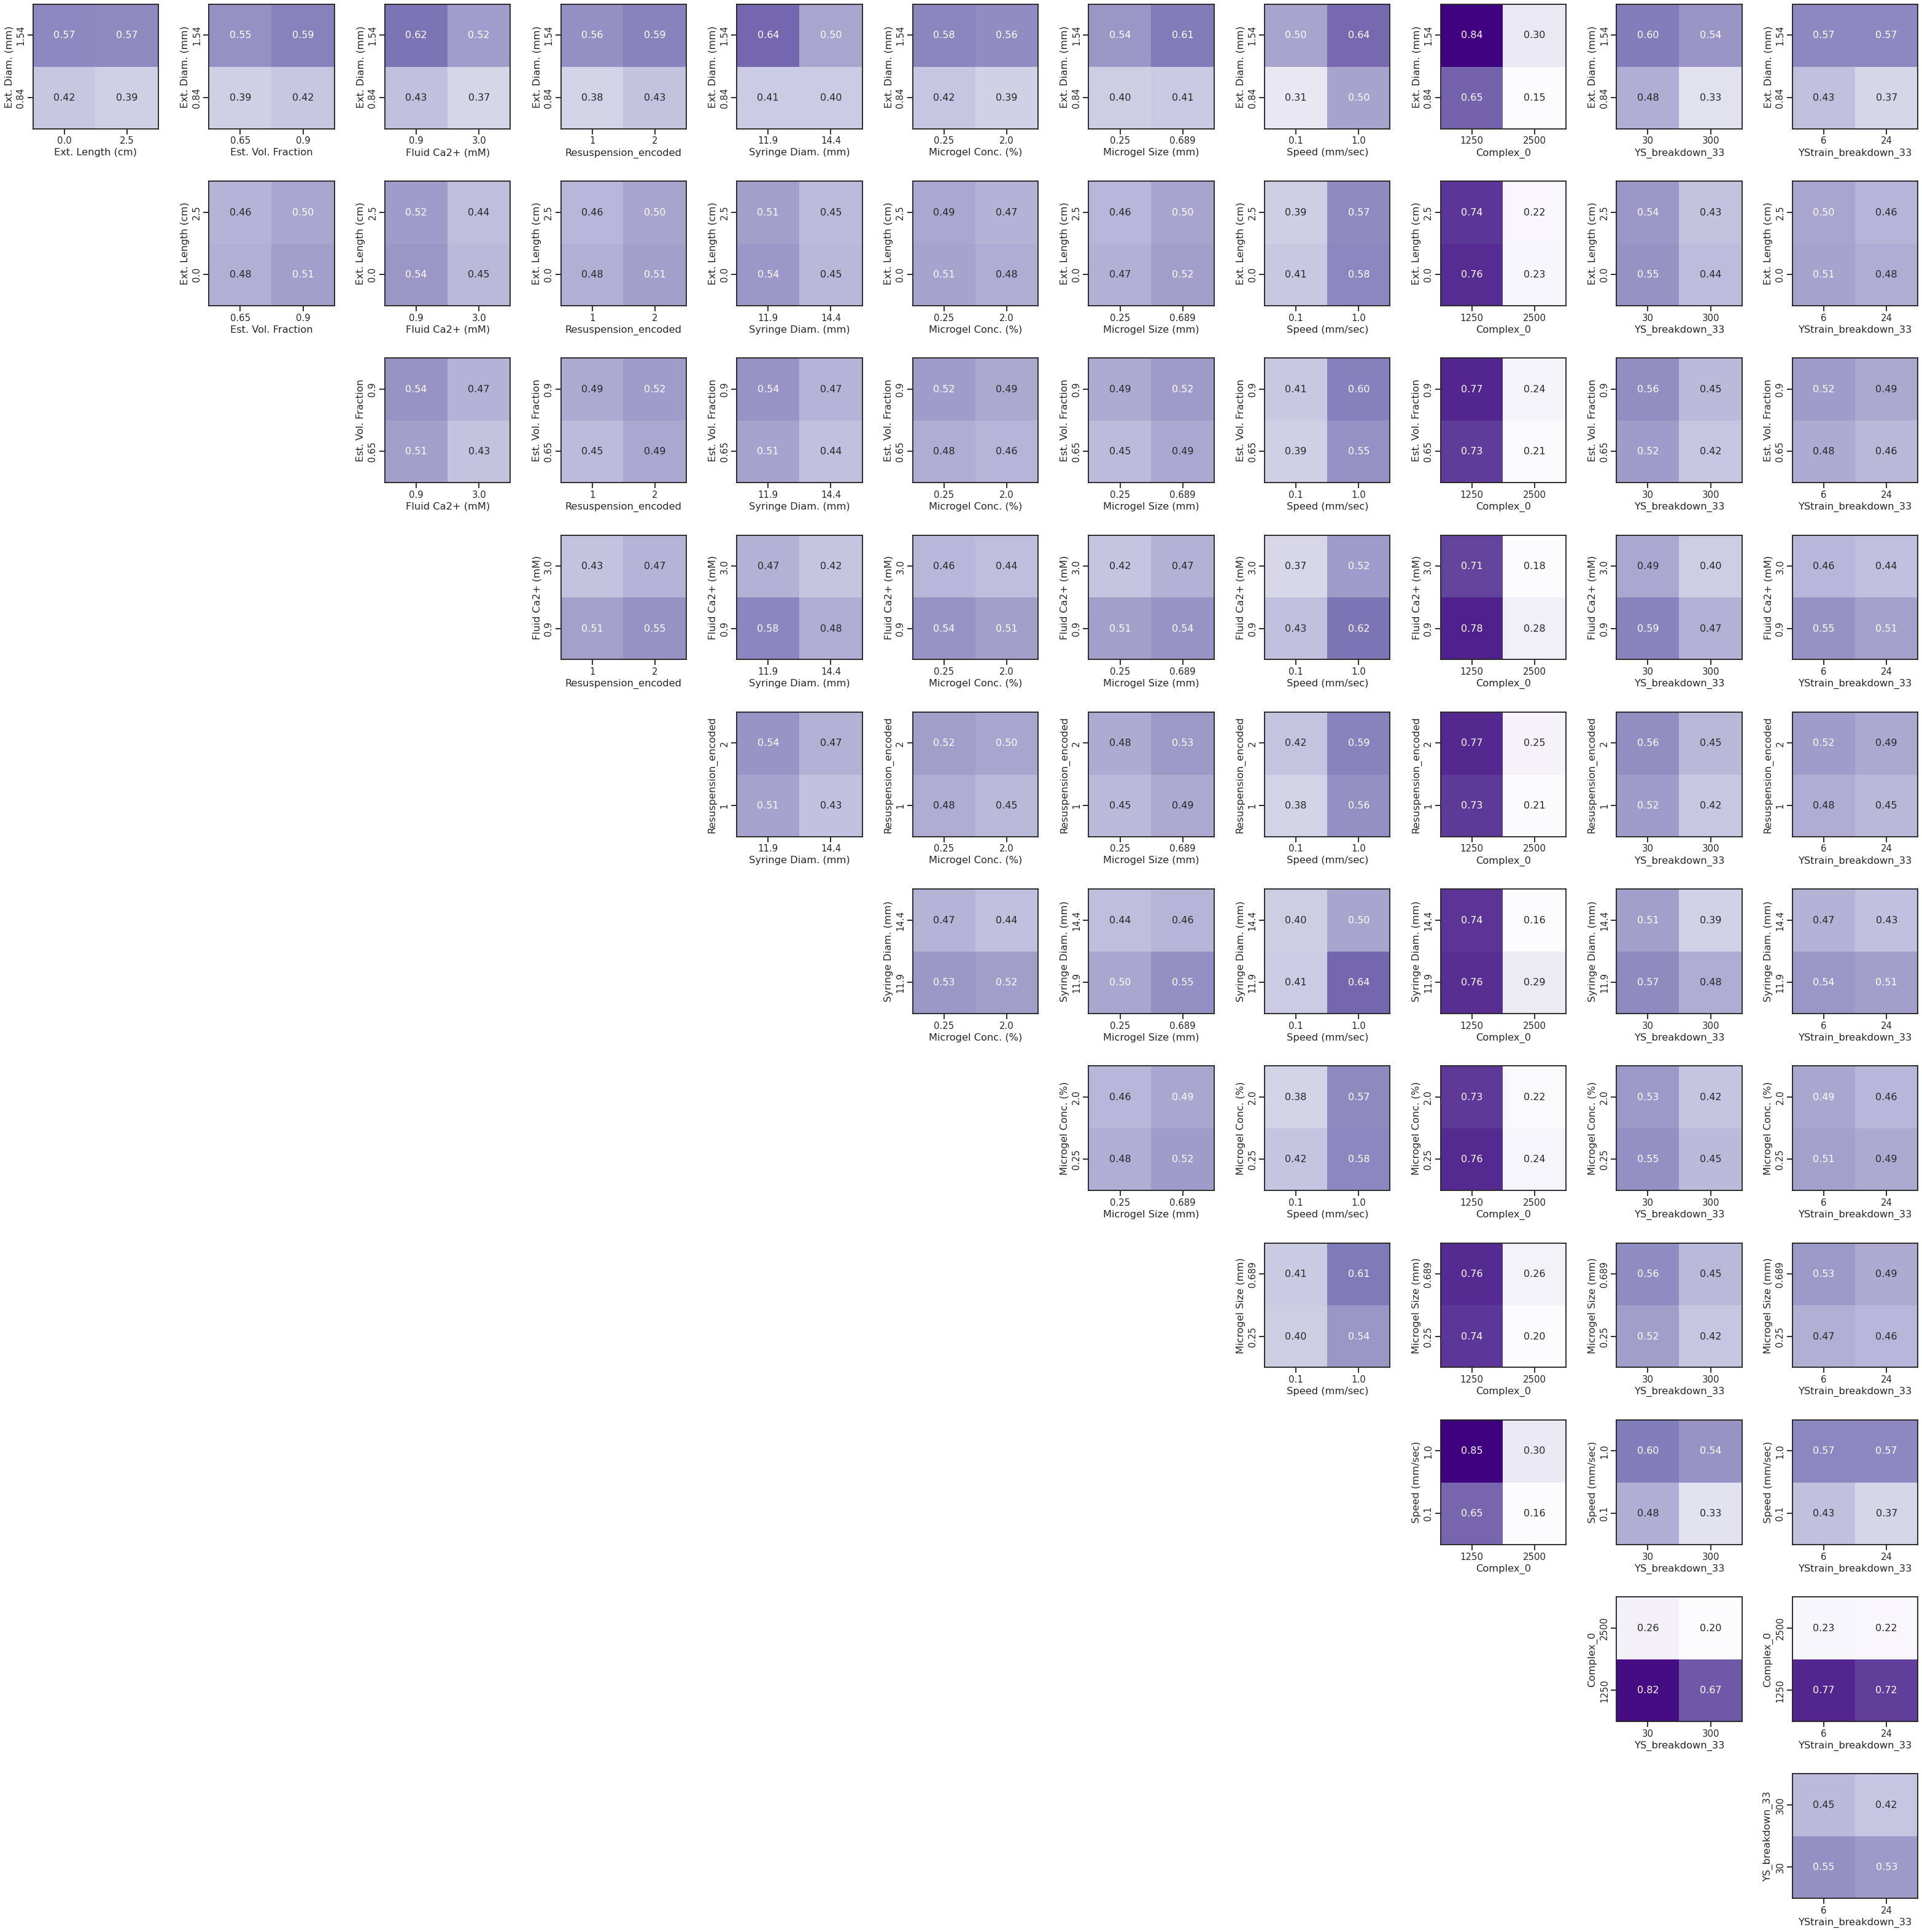

In [ ]:
# Define the columns you want to plot 
vars_to_iterate = X.columns

# Define the number of rows and columns 
rows=len(vars_to_iterate)-1;cols=len(vars_to_iterate)-1

# Define the figure 
fig,ax=plt.subplots(rows,cols,figsize=(cols*4, rows*4)); plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

# Define heatmap attributes 
vmin=0.2;vmax=0.85;cmap='Purples';annot=True;annot_size = 16;linewidth=0

# Initialize the row indexer, the column indexer, and an another variable to keep track of where the columns should start on a new row 
r,c,c_init=0,0,0

for pair in itertools.combinations(vars_to_iterate,2):   
  
  #print(r,c,c_init); print(pair)
  
  sns.heatmap(other_vars_constant.pivot_table(index=pair[0],columns=pair[1],values='Pred_probability'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax[r,c],linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)
  
  c+=1 # Mover over one column 

  if c == cols: # Check if you've reached the end of the row, in which case you need to move down by one and over by one 

    r+=1; c_init+=1; c=c_init # Move over one row, and then move over one column to maintain the diagonal structure of the matrix 

[ax.invert_yaxis() for ax in plt.gcf().axes] # Invert the y axis so the plot makes more sense

# Add the spines to each of the plots 
for ax in plt.gcf().axes: 
  for _, spine in ax.spines.items(): 
    spine.set_visible(True)

# Check if anything was actually added to the plot, and if there is no data you can delete the plot 
for ax in plt.gcf().axes: 
  if not ax.has_data(): 
    fig.delaxes(ax)

fig.tight_layout()

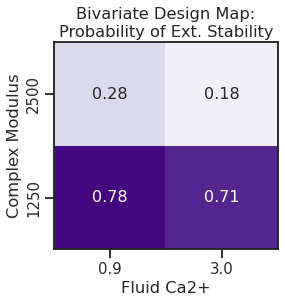

In [ ]:
rows=1;cols=1

fig,ax=plt.subplots(rows,cols,figsize=(cols*4.25, 4.5))

plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

vmin=0.1;vmax=0.8;cmap='Purples';annot=True;annot_size = 16;linewidth=0

sns.heatmap(other_vars_constant.pivot_table(index='Complex_0',columns='Fluid Ca2+ (mM)',values='Pred_probability'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax,linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)

ax.invert_yaxis() #ax.set_yticklabels(['Low','High'],va='center'); ax.set_xticklabels(['Soft','Stiff']); 

ax.set_xlabel('Fluid Ca2+'); ax.set_ylabel('Complex Modulus')

ax.set_title('Bivariate Design Map:\nProbability of Ext. Stability')

for ax in plt.gcf().axes:
  for _, spine in ax.spines.items():
      spine.set_visible(True)

fig.tight_layout()

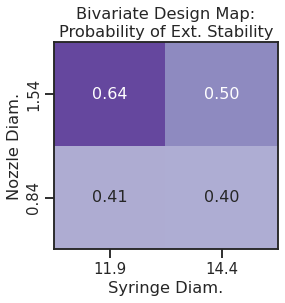

In [ ]:
rows=1;cols=1

fig,ax=plt.subplots(rows,cols,figsize=(cols*4.25, 4.5))

plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

vmin=0.1;vmax=0.8;cmap='Purples';annot=True;annot_size = 16;linewidth=0

sns.heatmap(other_vars_constant.pivot_table(index='Ext. Diam. (mm)',columns='Syringe Diam. (mm)',values='Pred_probability'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax,linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)

ax.invert_yaxis() #ax.set_yticklabels(['Low','High'],va='center'); ax.set_xticklabels(['Soft','Stiff']); 

ax.set_xlabel('Syringe Diam.'); ax.set_ylabel('Nozzle Diam.')

ax.set_title('Bivariate Design Map:\nProbability of Ext. Stability')

for ax in plt.gcf().axes:
  for _, spine in ax.spines.items():
      spine.set_visible(True)

fig.tight_layout()

### Supplementary Evaluation

In [ ]:
# Basic information about X and y 
print('Matrix of X values:',X.shape[0],'observations and',X.shape[1],'features')
print('Feature names:',list(X.columns))
print('Vector of y values:',y.shape[0],'observations')
print('y name(s):',y.name)
print('Number of observations of class 1:',y.value_counts()[1])
print('Number of observations of class 0:',y.value_counts()[0])
print('Number of unique trials:',np.unique(groups).shape[0])

Matrix of X values: 108 observations and 12 features
Feature names: ['Ext. Diam. (mm)', 'Ext. Length (cm)', 'Est. Vol. Fraction', 'Fluid Ca2+ (mM)', 'Resuspension_encoded', 'Syringe Diam. (mm)', 'Microgel Conc. (%)', 'Microgel Size (mm)', 'Speed (mm/sec)', 'Complex_0', 'YS_breakdown_33', 'YStrain_breakdown_33']
Vector of y values: 108 observations
y name(s): StabilityLabel
Number of observations of class 1: 88
Number of observations of class 0: 20
Number of unique trials: 108


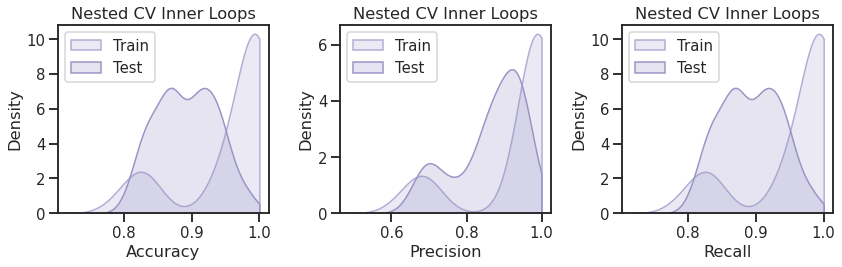

In [ ]:
# Plot the nested CV inner model evaluations 
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=compiled_inner_crossval['mean_train_'+scorer],clip=[0,1],shade=True,label='Train',ax=ax[indexer])
  sns.kdeplot(data=compiled_inner_crossval['mean_test_'+scorer],clip=[0,1],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Nested CV Inner Loops')
  indexer+=1
fig.tight_layout()

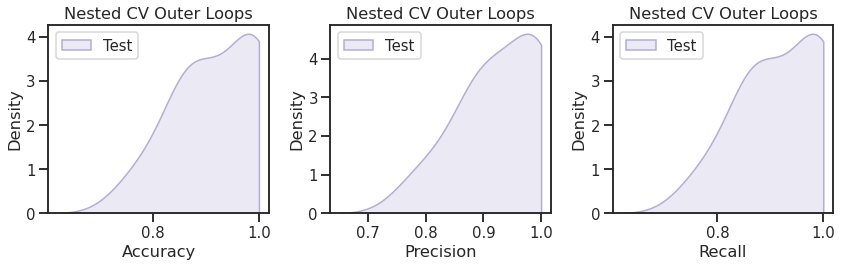

In [ ]:
# Plot the nested CV outer model evaluations
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=compiled_best_models['outer_'+scorer],clip=[0,1],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Nested CV Outer Loops')
  indexer+=1
fig.tight_layout()

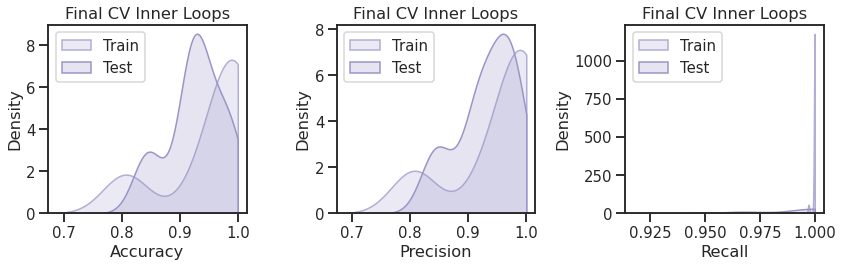

In [ ]:
# Plot the final CV inner model evaluations 
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=final_search_results['mean_train_'+scorer],clip=[0,1],shade=True,label='Train',ax=ax[indexer])
  sns.kdeplot(data=final_search_results['mean_test_'+scorer],clip=[0,1],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Final CV Inner Loops')
  indexer+=1
fig.tight_layout()

In [ ]:
# Compute the permutation feature importance 
from sklearn.inspection import permutation_importance

level_0 = []; level_00 = []
for key in selected.keys(): 
  perm_imp = permutation_importance(selected[key],X,y,n_repeats=10,random_state=1,n_jobs=-1) # Compute the permutation feature importances and store the results 
  perm_imp_raw = pd.DataFrame(data=perm_imp.importances, index=X.columns) # Raw perm feat imp values for each var
  perm_imp_means = pd.DataFrame({'Var_names': X.columns,'PI_mean': perm_imp.importances_mean,'PI_std': perm_imp.importances_std}) # Mean and std feat imp for each var
  level_0.append(perm_imp_means); level_00.append(perm_imp_raw)

# Combine all of the results into a multi-index 
pi_means = pd.concat(level_0,keys=selected.keys()); pi_raw = pd.concat(level_00,keys=selected.keys())

# Melt the dataframe and rename the columns (makes it easier for plotting)
pi_raw_melt = pd.melt(pi_raw.reset_index(),id_vars=['level_0','level_1'],value_vars=pi_raw.columns).drop(columns='variable').rename(columns={'level_0':'Model','level_1':'variable','value':'Permutation Feature Importance'})

# Sort the feature importance (avereged between the two models) so that they are plotted from highest (top) to lowest (bottom) on the graph 
sorted_by_mean = pi_raw_melt.groupby('variable').mean().sort_values(by='Permutation Feature Importance',ascending=False).reset_index().rename(columns={'Permutation Feature Importance':'Avg PF Importance'})

pi_raw_melt_full = pd.merge(sorted_by_mean,pi_raw_melt,on='variable'); pi_raw_melt = pd.merge(sorted_by_mean.iloc[:6],pi_raw_melt,on='variable')

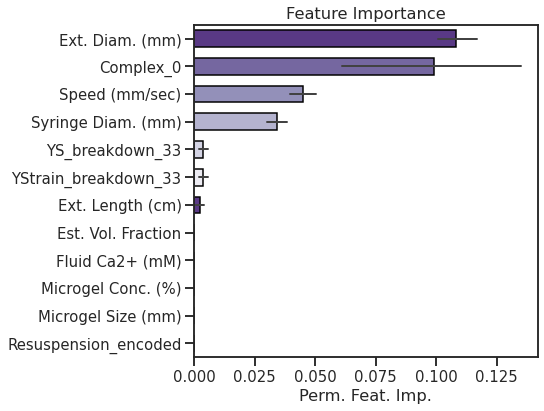

In [ ]:
fig = plt.figure(figsize=(8, 6))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

rows=1;cols=1

# Plot the permutation feature importance (bar plots for each variable - averaged) 

sub1 = fig.add_subplot(rows,cols,1) 

sns.barplot(y='variable',x='Permutation Feature Importance',data=pi_raw_melt_full,ax=sub1,edgecolor='k',errwidth=2,palette=sns.color_palette(palette='Purples_r'),alpha=1)

sub1.set_title('Feature Importance'); sub1.set_ylabel(''); sub1.set_xlabel('Perm. Feat. Imp.'); sub1.set_xlim(xmin=0)

def change_width_y(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height(); diff = current_width - new_value

        patch.set_height(new_value) # change the bar width

        patch.set_y(patch.get_y() + diff * .5) # recenter the bar
change_width_y(sub1, .6)

fig.tight_layout()

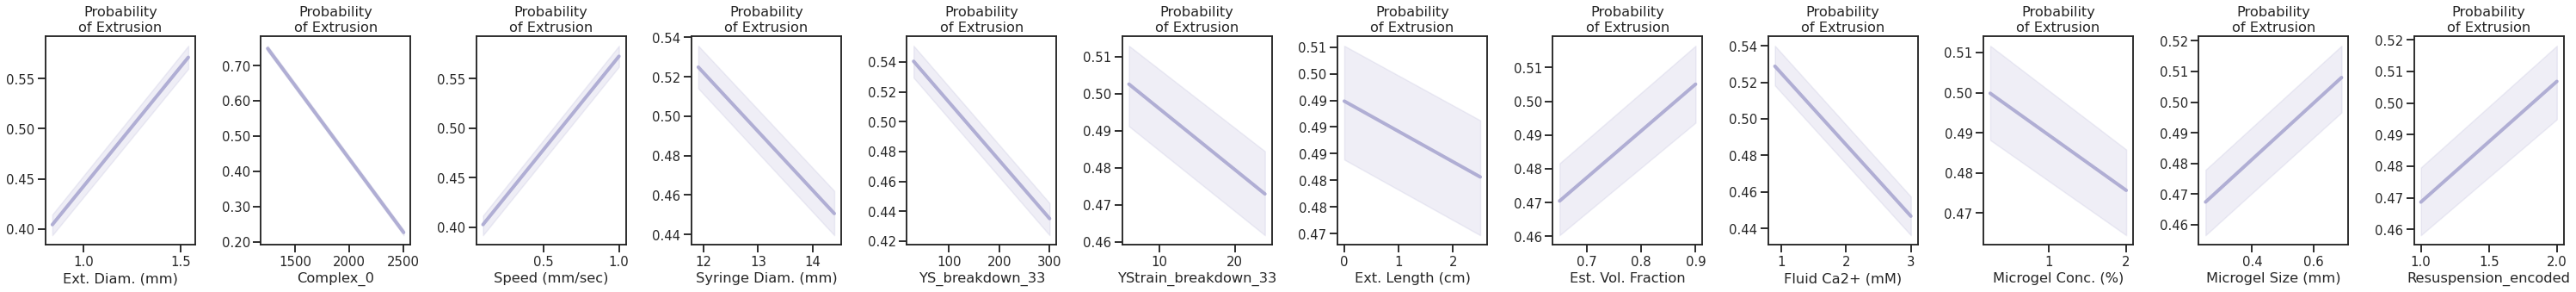

In [ ]:
# Plot the predicted values (given the n-dimensional cartesian product of unique feature values) along each possible feature axis 

yval = 'Pred_probability'; title = 'Probability\nof Extrusion'; format = '%.2f' # Modify these as needed 

from matplotlib.ticker import FormatStrFormatter

ordered_preds = pi_raw_melt_full.groupby('variable').mean().sort_values(by='Permutation Feature Importance',ascending=False).index.values

fig = plt.figure(figsize=(len(ordered_preds)*3.5, 5))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

rows=1;cols=len(ordered_preds) 

dict_for_pred_plots = {}
for i in range(len(ordered_preds)): 
  dict_for_pred_plots['sub'+str(i)] = fig.add_subplot(rows,cols,i+1)
  sns.lineplot(x=ordered_preds[i],y=yval,data=other_vars_constant,ax=dict_for_pred_plots['sub'+str(i)],linewidth=4,color=sns.color_palette(palette='Purples_d')[0],)
  dict_for_pred_plots['sub'+str(i)].set_title(title); dict_for_pred_plots['sub'+str(i)].set_ylabel('');
  dict_for_pred_plots['sub'+str(i)].yaxis.set_major_formatter(FormatStrFormatter(format))

fig.tight_layout()

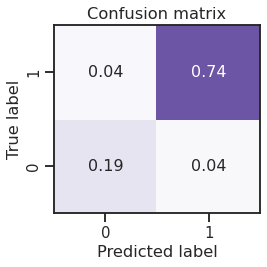

In [ ]:
from sklearn.metrics import confusion_matrix

rows=1;cols=1

fig,ax=plt.subplots(rows,cols,figsize=(cols*4,4))

plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

vmin=0;vmax=1;cmap='Purples';annot=True;annot_size = 16;linewidth=0

conf_mat = confusion_matrix(compiled_outer_crossval['y_test'], compiled_outer_crossval['yhat'],normalize='all')
sns.heatmap(conf_mat,vmin=vmin,vmax=vmax,cmap=cmap,ax=ax,linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)

ax.invert_yaxis(); 

ax.set_xlabel('Predicted label'); ax.set_ylabel('True label'); 

ax.set_title('Confusion matrix');

for ax in plt.gcf().axes:
  for _, spine in ax.spines.items():
      spine.set_visible(True)
fig.tight_layout()

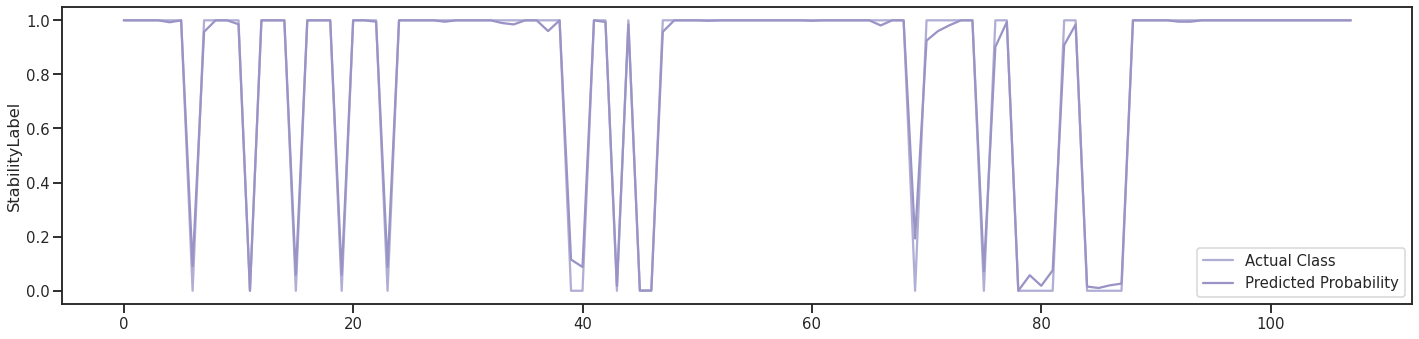

In [ ]:
# 
fig,ax=plt.subplots(figsize=(20,5))
sns.lineplot(x=np.arange(len(y)),y=y,ax=ax,label='Actual Class')
sns.lineplot(x=np.arange(len(y)),y=np.mean([rf.predict_proba(X)[:,1],gbm.predict_proba(X)[:,1]],axis=0),ax=ax,label='Predicted Probability')
fig.tight_layout()